> Extracting images from video
done


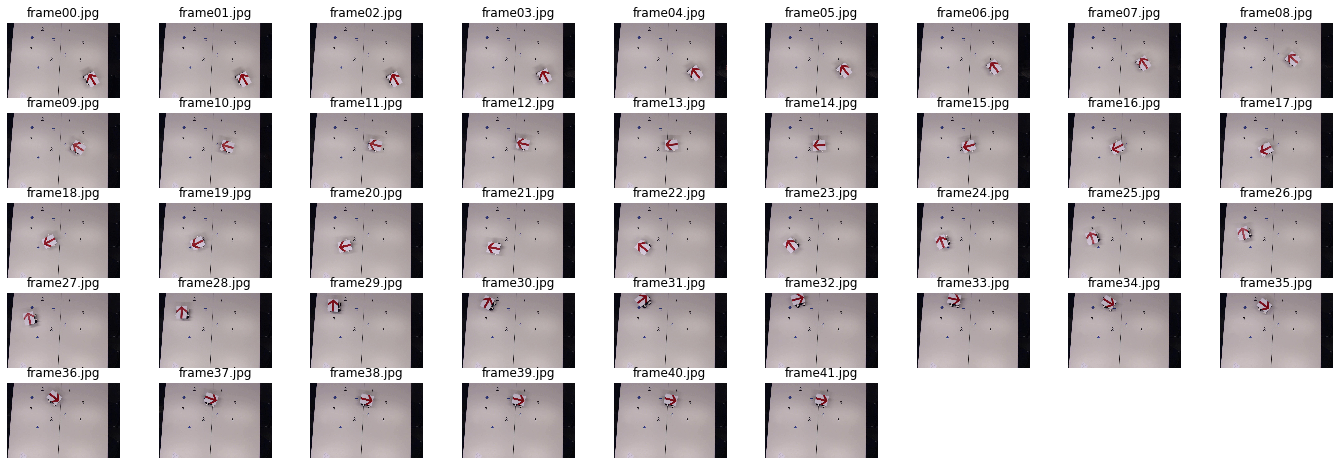

In [1]:
%matplotlib inline
from helpers import extract_images, load_data
import matplotlib.pyplot as plt
import numpy as np

# extract images from video
extract_images(data_path='./data/robot_parcours_1.avi')

# load data from extracted images
images, images_names = load_data(plot_images=True)

In [2]:
from helpers import get_arrow_bb, segmentation, get_object_bb, get_arrow_bb_test, Overlap, crop_image, get_features
import matplotlib.patches as mpatches
import math 
from digit_model import ConvNet
import torch
import os 
import pickle
positions = []
operation_order = []
label_order = []
cropped_object = []

model = ConvNet()
model.load_state_dict(torch.load('model_bin'))
model.eval()
classes = {0:'+', 1:'=', 2:'-', 3:'/', 4:'*'}
model_operator = pickle.load(open('model_operators.sav', 'rb'))
result = 0

if not os.path.exists('output'):
    os.makedirs('output')

order = 0
for ind, im in enumerate(images): 
    if ind == 0: 
        arrow_bb = get_arrow_bb(images[0])
        segmented = segmentation(images[0], arrow_bb)
        boxes = get_object_bb(segmented)
    
    fig, ax = plt.subplots()
    ax.imshow(im)
    ax.axis('off') 
    
    # Robot bb
    arrow_bb, orientation, minor_axis_length, major_axis_length, centroid = get_arrow_bb_test(im)
    minr_a, minc_a, maxr_a, maxc_a = arrow_bb
    x_robot, y_robot = minc_a+(maxc_a-minc_a)/2, minr_a+(maxr_a-minr_a)/2
    rect_a = mpatches.Rectangle((minc_a, minr_a), maxc_a - minc_a, maxr_a - minr_a, fill=False, edgecolor='red', linewidth=0.5)
    ax.add_patch(rect_a)
    #ax.annotate('ROBOT', (x_robot-(maxc_a - minc_a)/2, y_robot-3-(maxr_a - minr_a)/2), color='r', fontsize=4)
    
    #y0, x0 = centroid
    #x1 = x0 + math.cos(orientation) * 0.42 * major_axis_length
    #y1 = y0 - math.sin(orientation) * 0.42 * major_axis_length
    #x2 = x0 - math.sin(orientation) * 0.42 * major_axis_length
    #y2 = y0 - math.cos(orientation) * 0.42 * major_axis_length
    #ax.plot((x0, x2), (y0, y2), '-b', linewidth=0.75)
    #ax.plot((x0, x1), (y0, y1), '-b', linewidth=0.75)
    #ax.plot(x0, y0, '.b', markersize=5)
    #rad = 0.42 * major_axis_length
    #circle = mpatches.Circle((x0, y0), rad, fill=False, edgecolor='k', linewidth=0.75)
    #ax.add_patch(circle)
    
    # Object bb
    for box in boxes:
        minr, minc, maxr, maxc = boxes[box]
        x, y = minc+(maxc-minc)/2, minr+(maxr-minr)/2
        rect = mpatches.Rectangle((x-25, y-25), 50, 50, fill=False, edgecolor='blue', linewidth=0.5)
        
        # Overlap btw boxes 
        if Overlap([minc_a, minr_a], [maxc_a, maxr_a], [x-25, y-25], [x+25, y+25]):
            if box not in label_order:
                crop_im = crop_image(images[0], [int(x-25), int(y-25), int(x+25), int(y+25)])
                crop_im = crop_im > 0.5
                if order%2 == 0: # even -> classify digit
                    digit_test = torch.from_numpy(np.array(crop_im).astype(np.float32)).reshape(1,1,40,40) 
                    output_test = model(digit_test).softmax(1)
                    _, predicted_classe = torch.max(output_test, 1)
                    predicted_classe = predicted_classe.item()
                    order += 1
                else: # odd -> classify operators 
                    crop_im = crop_im.astype(float)
                    features = get_features(crop_im,6)
                    predicted_classe = classes[int(model_operator.predict(np.expand_dims(features, axis = 0)))]
                    order += 1
                    
                cropped_object.append(crop_im)
                label_order.append(box)
                operation_order.append(predicted_classe)
        else:
            ax.add_patch(rect)
            ax.annotate(box, (x-25, y-28), color='b', fontsize=4)
    
    # Robot positions
    if len(positions) > 1:
        for last, pos in zip(positions,positions[1:]):
            point = mpatches.Circle(pos, 2, color='r')
            ax.add_patch(point)
            ax.plot((last[0], pos[0]), (last[1], pos[1]), '-k', linewidth=0.5)
    
    if ind > 0:
        positions.append((x_robot, y_robot))
    
    # Operation order display
    string = ''
    if operation_order:
        for op in operation_order:
            string += str(op)
            if op == '=':
                result = eval(string[:len(string)-1])
                string += str(result)
    
    ax.annotate(string, (50, 400), color='g', fontsize=8)

    if ind < 10:
        plt.savefig('./output/red_arrow_0'+str(ind)+'.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    else: 
        plt.savefig('./output/red_arrow_'+str(ind)+'.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

In [3]:
from helpers import frames_to_video

inputpath = './output/'
outpath =  './output/video.avi'
fps = 4
frames_to_video(inputpath, outpath,fps)

In [4]:
print(operation_order)

[3, '/', 2, '+', 7, '*', 2, '=']


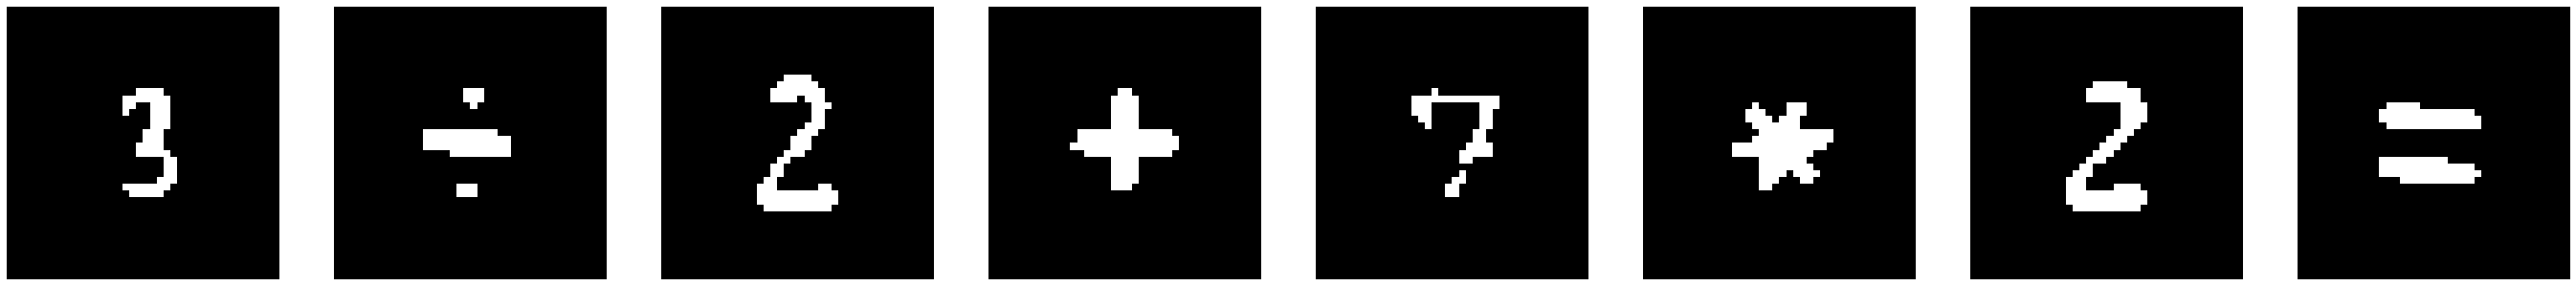

In [5]:
fig, axes = plt.subplots(1, len(cropped_object), figsize=(48,12))
ax = axes.ravel()
for ind, crop in enumerate(cropped_object): 
    ax[ind].imshow(crop, cmap='gray')
    ax[ind].axis('off')